In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score #R-squared
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error#for train and test split
from statsmodels.api import qqplot 
from scipy.stats import shapiro,ttest_ind
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  
from sklearn import linear_model

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [96]:
# read the data 

data = pd.read_excel(r'C:\\Users\\User\\Downloads\\Student_data.xlsx')

C:\Users\User\anaconda3\desktop\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [97]:
data.head(3)

,StudentID,school2,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
0,1,GP,F,18,U,GT3,A,4,4,at_home,...,no,no,4,3,4,1,1,3,6,6
1,2,GP,F,17,U,GT3,T,1,1,at_home,...,yes,no,5,3,3,1,1,3,4,6
2,3,GP,F,15,U,LE3,T,1,1,at_home,...,yes,no,4,3,2,2,3,3,10,10


In [98]:
#looking at the columns of the dataset

print(data.columns.tolist())
print(" ")
print("We have overall", len(data.columns), "columns")

['StudentID', 'school2', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Final_Grade']
 
We have overall 32 columns


In [99]:
print("The shape of our data is:", data.shape)

The shape of our data is: (395, 32)


In [100]:
data.describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,198.000000,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.415190
std,114.170924,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,4.581443
min,1.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,99.500000,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000
50%,198.000000,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000
75%,296.500000,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000
max,395.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000


When looking at the data descibe, we can some descriptive information about each variable, can think of a possible distribution. 
1. StudentID does not give us any important information from this perspective, sincce it's not made for modeling purposes. 
2. Age: looking at the description of the variable, we can see that the age of the students is between 15 to 22. The average age is about 17. Also, we can see info about the major quantiles and how the variable is spread through them. 

Let's skeep the other variables for now

## Studying about and handling the missing and unique values

In [101]:
print("Overall number of missing values is", data.isna().sum().sum())

Overall number of missing values is 0


In [102]:
print("Overall number of duplicate values is:", data.duplicated().sum())

Overall number of duplicate values is: 0


As we can see, we do not have nulls and can continue working with our data without deleting the rows or making changes in the values.  

In [103]:
data.columns[data.columns.nunique==1]

array([], shape=(0, 32), dtype=object)

Also, as we can see, no variable has 1 unique value... If we had such one, we would need to derop that 

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StudentID    395 non-null    int64 
 1   school2      395 non-null    object
 2   sex          395 non-null    object
 3   age          395 non-null    int64 
 4   address      395 non-null    object
 5   famsize      395 non-null    object
 6   Pstatus      395 non-null    object
 7   Medu         395 non-null    int64 
 8   Fedu         395 non-null    int64 
 9   Mjob         395 non-null    object
 10  Fjob         395 non-null    object
 11  reason       395 non-null    object
 12  guardian     395 non-null    object
 13  traveltime   395 non-null    int64 
 14  studytime    395 non-null    int64 
 15  failures     395 non-null    int64 
 16  schoolsup    395 non-null    object
 17  famsup       395 non-null    object
 18  paid         395 non-null    object
 19  activities   395 non-null    

As we can see, all of our variables are objects or integers, which makes the work easier, no need for additional work here. 

In [105]:
data.nunique()

StudentID      395
school2          2
sex              2
age              8
address          2
famsize          2
Pstatus          2
Medu             5
Fedu             5
Mjob             5
Fjob             5
reason           4
guardian         3
traveltime       4
studytime        4
failures         4
schoolsup        2
famsup           2
paid             2
activities       2
nursery          2
higher           2
internet         2
romantic         2
famrel           5
freetime         5
goout            5
Dalc             5
Walc             5
health           5
absences        34
Final_Grade     18
dtype: int64

The above code shows the number of unique values for each variable. This helps to understand the need of modifications before dummifying the categorical variables to decrease the number of unnecessary categories. 

### Going through the categories

By using the following method, we can look through each variable and understand the existing categories

In [106]:
print(type(data.famsize))
print(data.famsize.unique())

<class 'pandas.core.series.Series'>
['GT3' 'LE3']


We can run a loop and see the unique values of each variable 

In [107]:
for col in data:
    print("The unique value in ",col,"are:" , data[col].unique())
    print(col, ": \n", data[col].value_counts(), "\n ........")

The unique value in  StudentID are: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 23

## Understanding the Distributions

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Final Grade Distribution'}, xlabel='Final_Grade', ylabel='Density'>

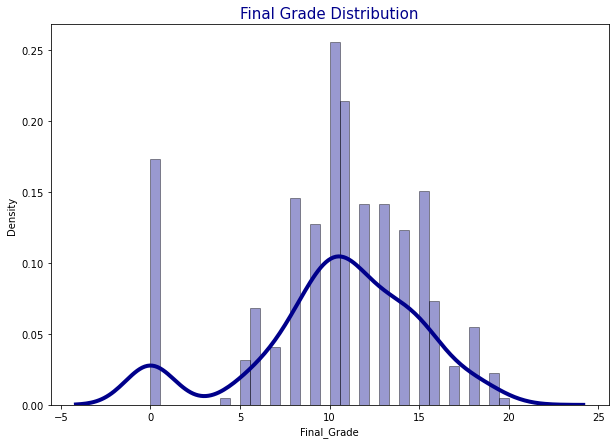

In [108]:
# Density Plot and Histogram for the Final Grade 
plt.figure(figsize = (10,7))
plt.title("Final Grade Distribution",fontsize = 15, color = 'darkblue') 
sns.distplot(data.Final_Grade, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Without the point 0,  the distribution of Final Grade would be similar to Normal distribution. Howevfer, a lot of students got 0 and the distribution has some gaps. 

### Let's look at the outliers 
As the final grade has a specific range, most probably, we will not have any outliers 

No handles with labels found to put in legend.


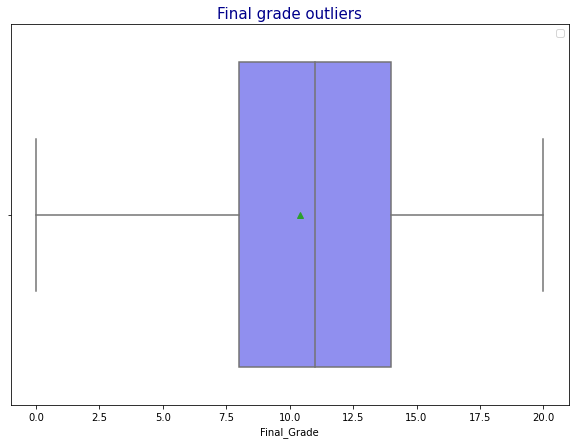

In [109]:
plt.figure(figsize = (10,7))
sns.boxplot(x="Final_Grade",data=data, palette='cool',hue=data.paid,  showmeans=True)
plt.legend()
plt.title('Final grade outliers',fontsize = 15, color = 'darkblue')
plt.show()

Here we can see that the 50% quantile of final grade is about 11, here we do not have outliers. Most of the values are centered on the right side, meaning, they are higher than 10 in this case. 

Let's look some other variables' distributions as well

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


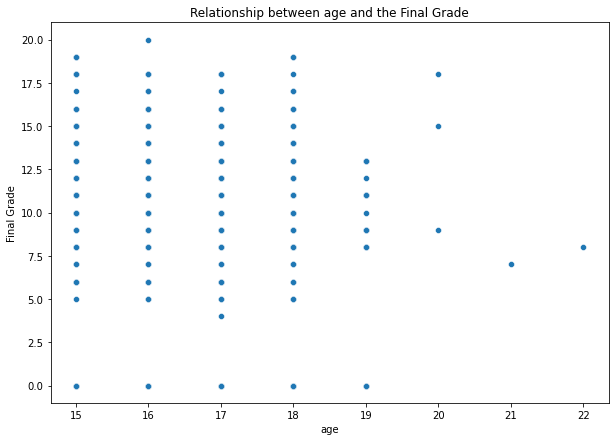

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


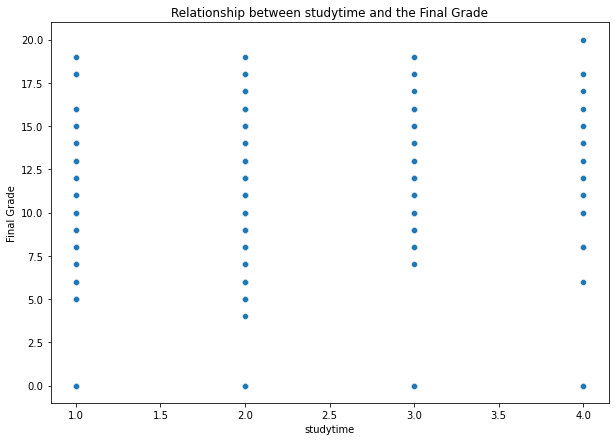

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


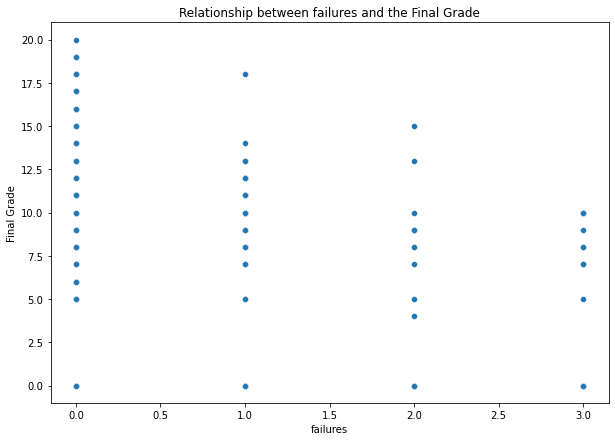

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


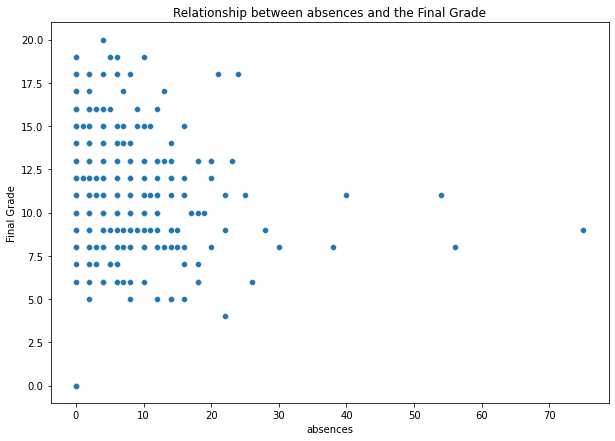

In [110]:
for i in ["age", "studytime", "failures", "absences"]:
    plt.figure(figsize = (10,7))
    sns.scatterplot(data[i],data["Final_Grade"])
    plt.xlabel(i)
    plt.ylabel("Final Grade")
    plt.title(f"Relationship between {i} and the Final Grade")
    plt.show()

The above cell shows scatterplots of the given variables (age, studytime, failures, absences) and final grade. 

### The following Bubble plot shows the connection between absences and final grade, where failures are mentioned

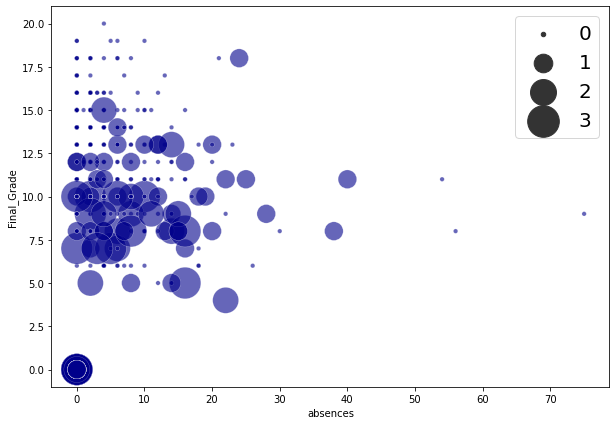

In [111]:
plt.figure(figsize = (10,7))

sns.scatterplot(data=data, x="absences", y="Final_Grade", size="failures", 
                legend=True, sizes=(20, 1000), alpha=0.6, color = 'darkblue')
plt.legend( prop={"size":20})
# show the graph
plt.show()

As we can see, as the number of failures increases, the final rade decreases. Also, the more the absences are, the lower the grade is. 

In [112]:
np.corrcoef(data.absences,data.Final_Grade)

array([[1.        , 0.03424732],
       [0.03424732, 1.        ]])

In [113]:
np.corrcoef(data.failures,data.Final_Grade)

array([[ 1.        , -0.36041494],
       [-0.36041494,  1.        ]])

## Separating object and numeric datatypes

In [114]:
# separate numeric and object parts 

data_num = data.select_dtypes(exclude = ["object"])
data_obj = data.select_dtypes(include = ["object"])

In [115]:
print("The shape of the numeric data is:", data_num.shape)
print("The shape of the object data is:", data_obj.shape)

The shape of the numeric data is: (395, 15)
The shape of the object data is: (395, 17)


Looking at the unique values, we can see that no varible has "unnecessary" category, which can be grouped with other variables. 

As we can see, in both mother's case and  father's case, healthcare job has the lowest number. So, let's group it with the "other" category, in order not to have so many variables after dummifying. 

## Working with categorical variables

### Let's graphically interpret the differences between the categories of object types and final grade

In [116]:
list_obj = data_obj.columns.tolist()

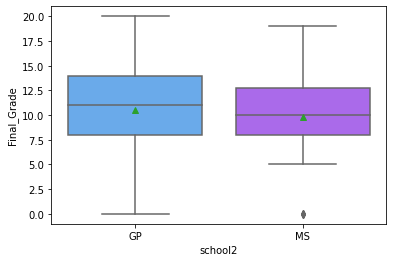

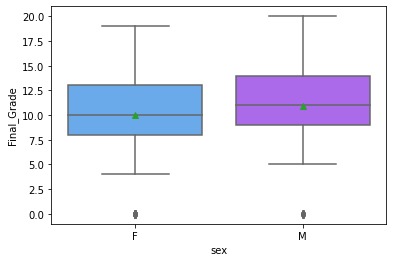

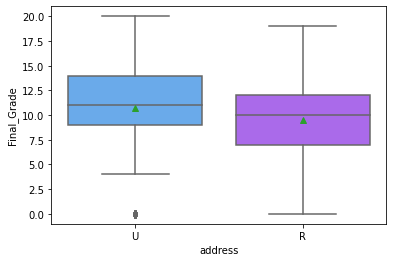

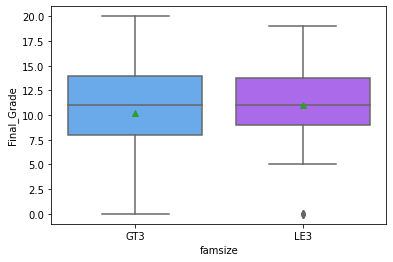

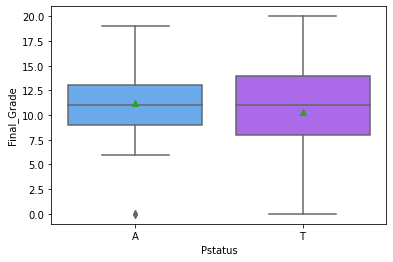

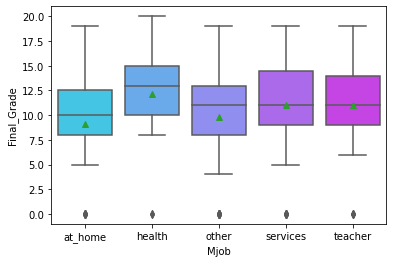

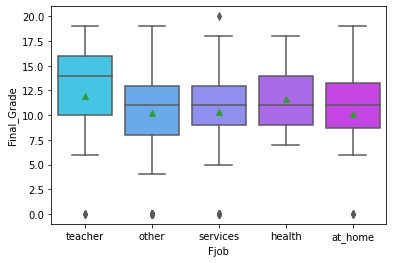

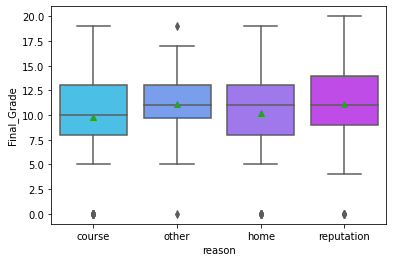

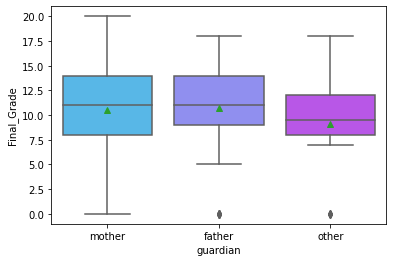

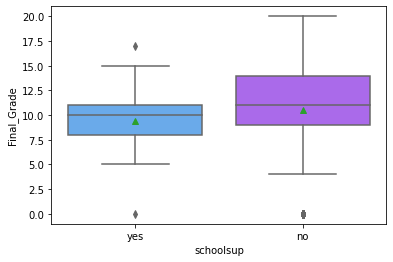

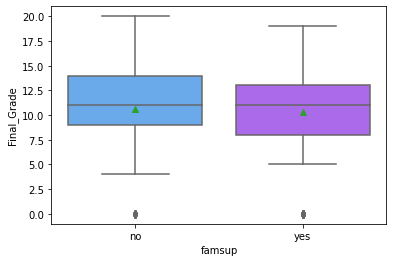

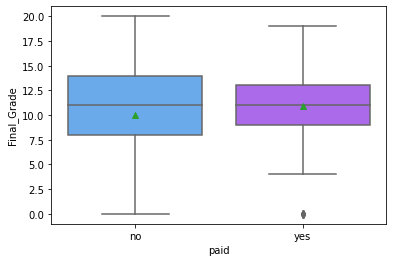

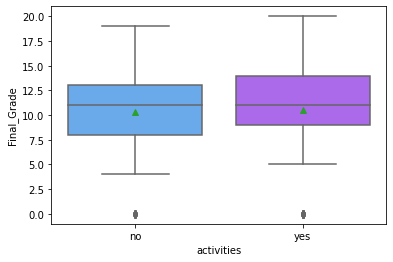

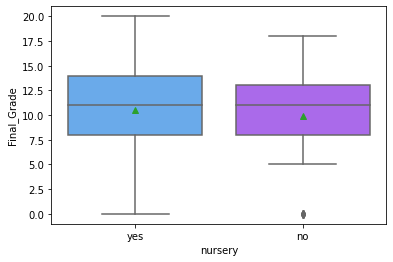

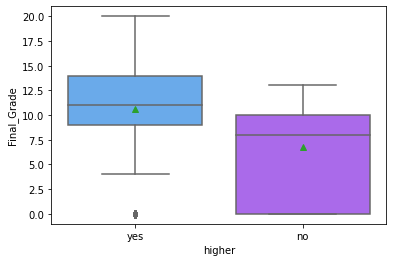

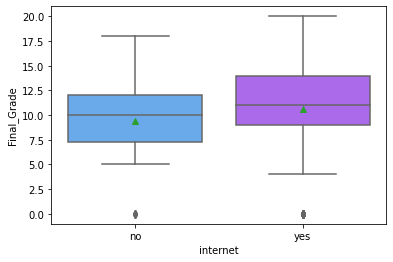

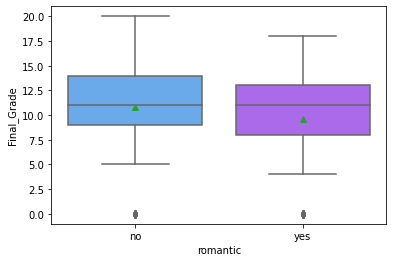

In [117]:
#for comparing Final grade with categorical variables it represented in boxplot
#We can see difference in final grades by address,Fjob teacher level,Mjob at health level,internet, schoolsup,higher.
for i in list_obj:
    sns.boxplot(data=data,x=i,y="Final_Grade", showmeans=True, palette='cool')
    plt.show()

1. School2 
As we can see, in terms of grades GP has higher average (median) grade, however, the grade range is higher. 

2. Sex
Results show that males tend to get higher grades than females 

3. Address
The students from urban areas tend to get higher scores. Their distribution is approximatelly looking like normal, and the range is smaller than that of Region students 

4. Famsize 
In both cases, the median is approximately equal 

5. Pstatus 
Apart has smaller grade range, but has an outlier 


etc. 
Let's leave the other variables, since nothing interesting can be interpreted 

## Working with numeric variables

In [118]:
data_num.head()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
0,1,18,4,4,2,2,0,4,3,4,1,1,3,6,6
1,2,17,1,1,1,2,0,5,3,3,1,1,3,4,6
2,3,15,1,1,1,2,3,4,3,2,2,3,3,10,10
3,4,15,4,2,1,3,0,3,2,2,1,1,5,2,15
4,5,16,3,3,1,2,0,4,3,2,1,2,5,4,10


Let's see which variables have high correlation which do not.  
Here, let's take 0.8 as the decision making number, meaning, if the correlation is higher or equal to 0.8 we are going to decide on keeping or deleting one of the variables. 

<AxesSubplot:>

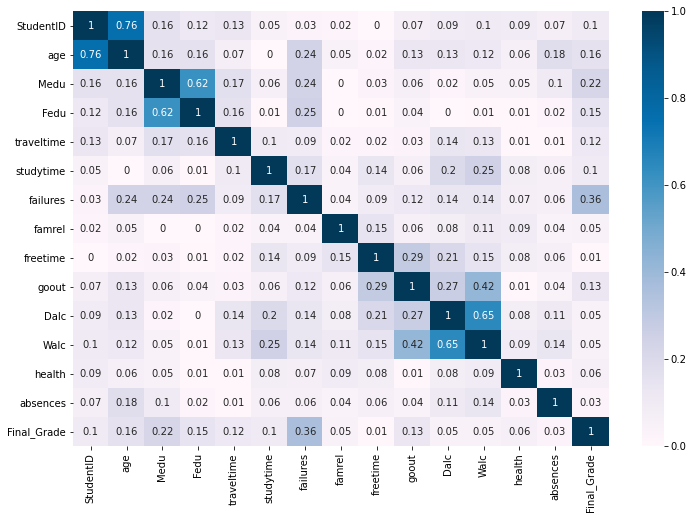

In [119]:
# correlation heatmap for examining multicollinearity

plt.figure(figsize = (12,8))
sns.heatmap(data_num.corr().abs().round(2), annot =True, cmap="PuBu")

Here the variables do not have strong correlation. As we can see from the graph, none of them had >=0.8 correlation. 
Only, studentID and age have high correlation. But the variables are not related, and rationally thinking, studentID does not have any impact on the final grade. 

Walc and Dalc have the seond highest values. Logically, they can have some correlation, in a sense that a person likes drinking alcohol or not. However, the results are less than the target value, so let's leave the variables. 

Since we do not need ID variable for the modeling, let's remove that 

In [120]:
data = data.drop("StudentID", axis = 1)

In [121]:
data_num = data_num.drop("StudentID", axis = 1)

<Figure size 432x288 with 0 Axes>

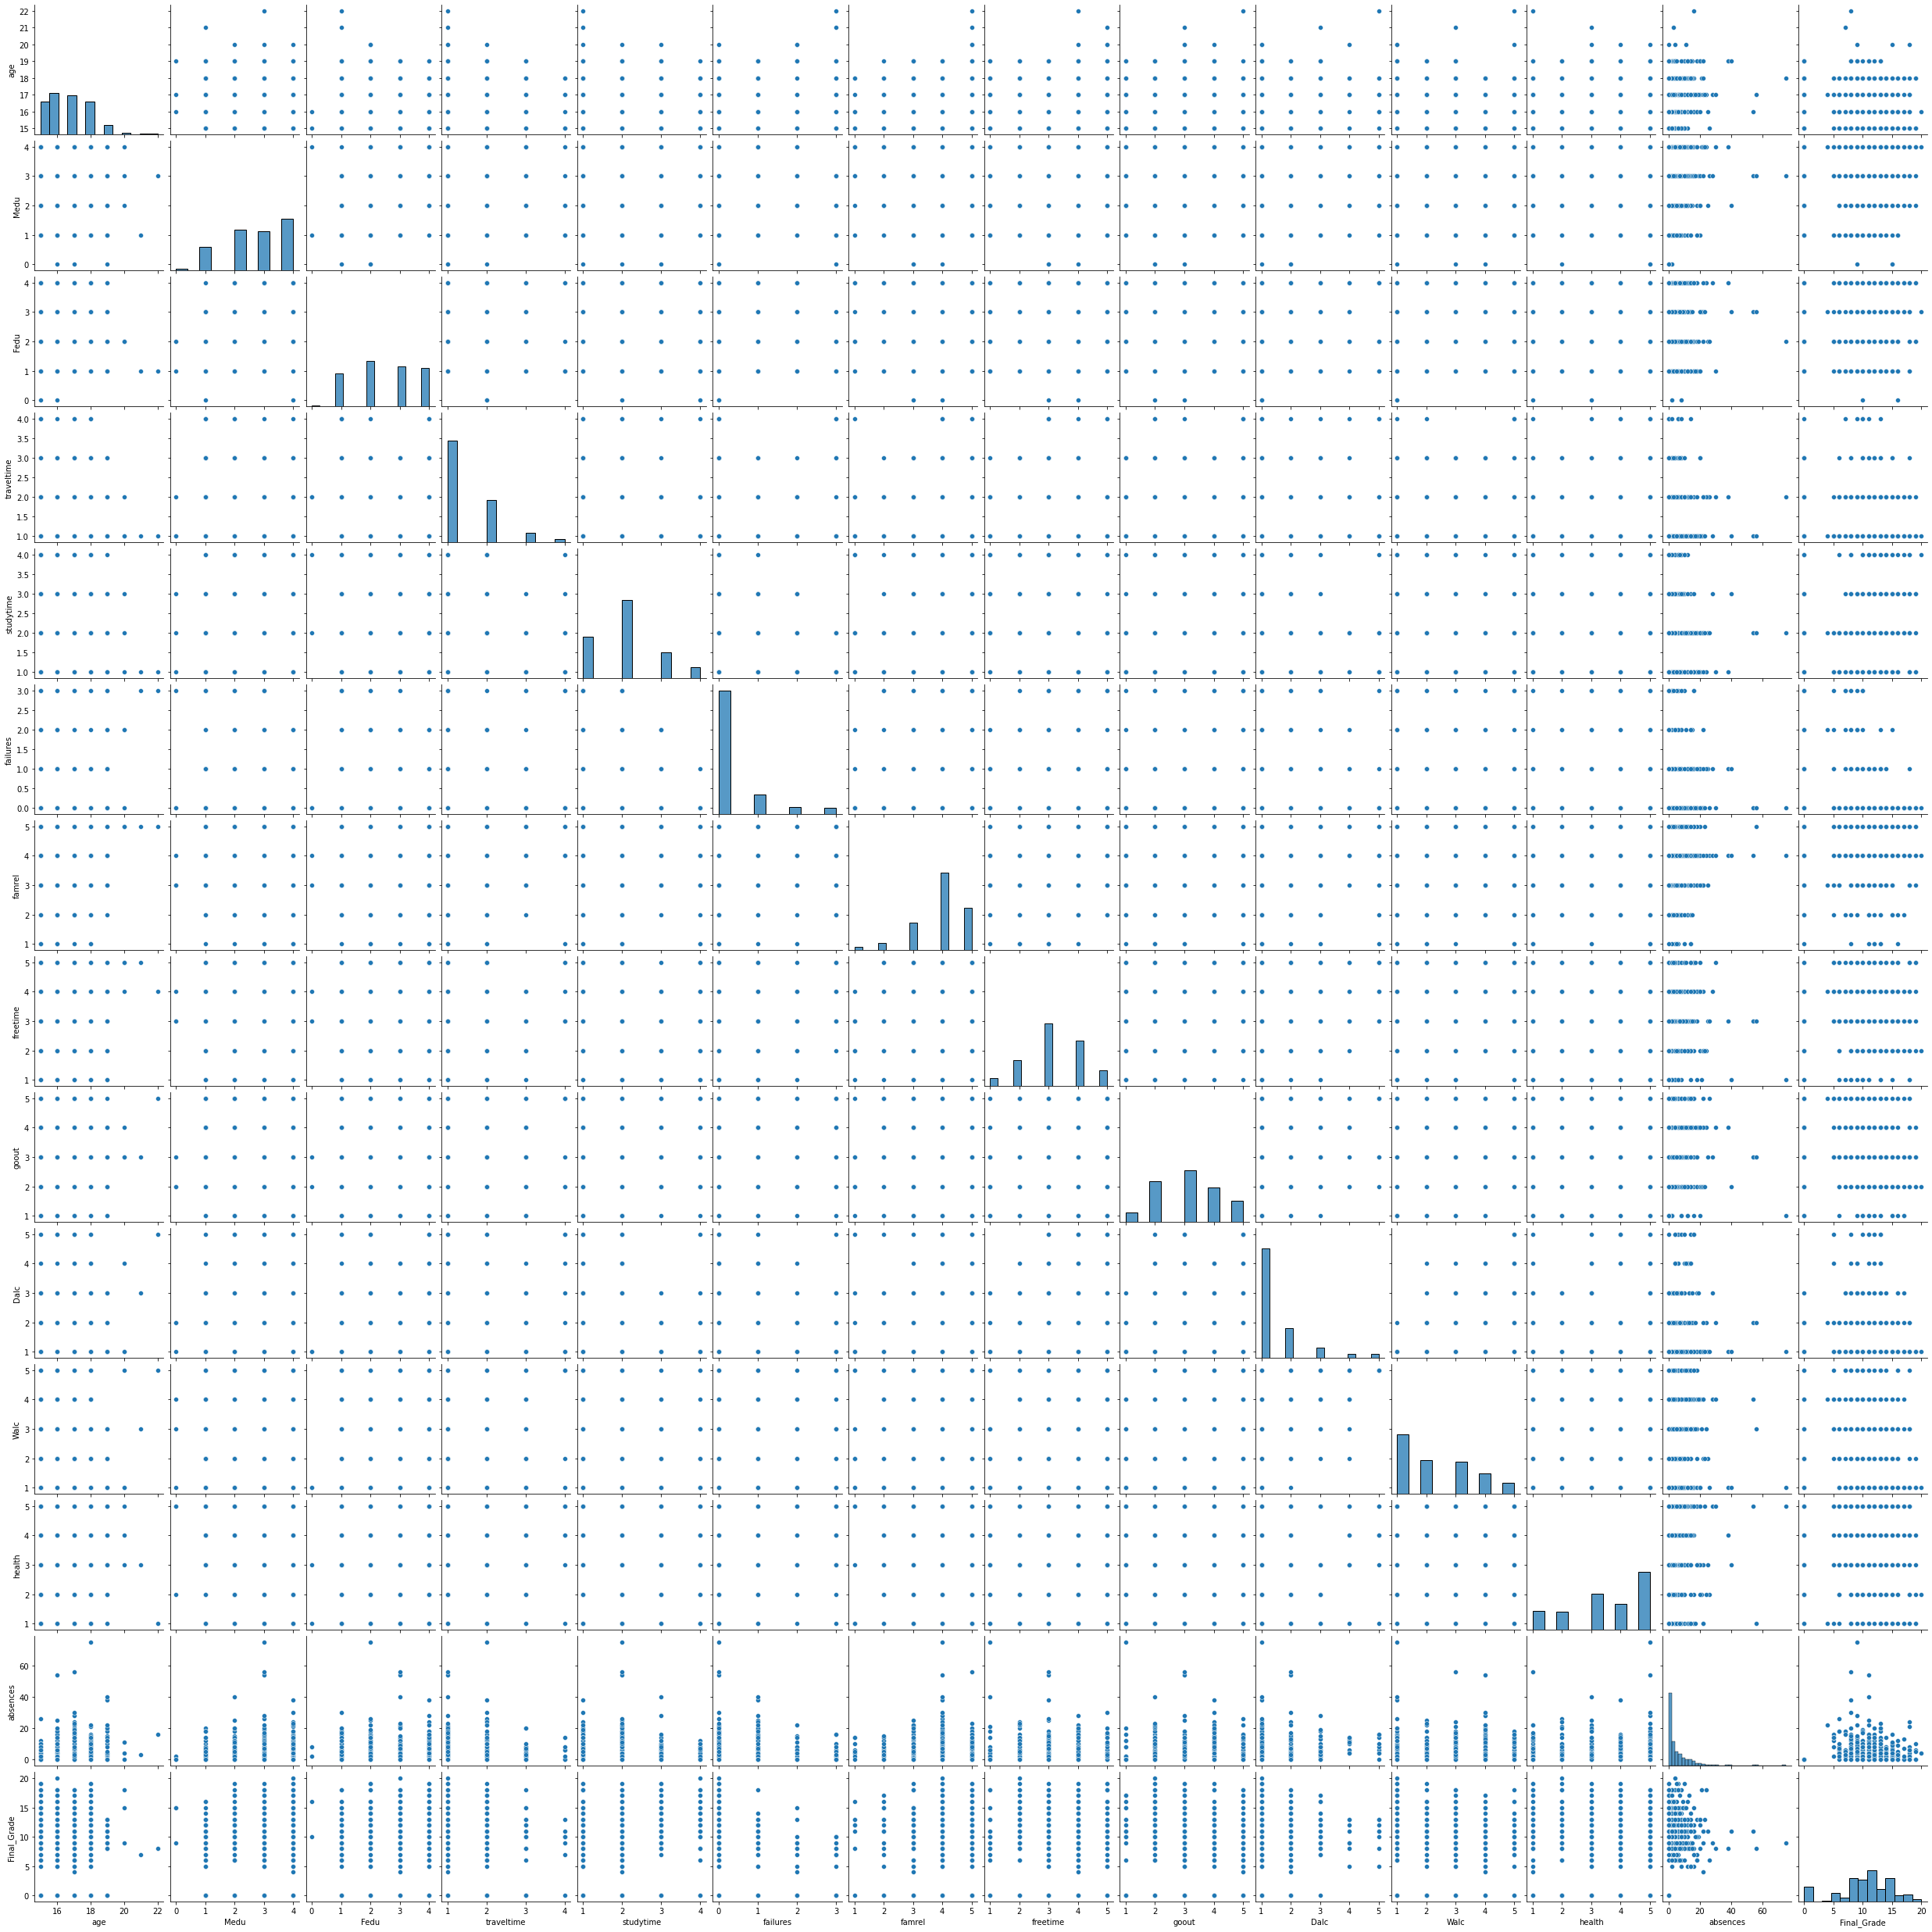

In [122]:
plt.figure(figsize = (6,4))
sns.pairplot(data_num)


# Visual representation of pairwise relationships
# The plot is made to see the highest correlated variables with the Final Grade

The graph shows the linear relationship between the Final Grade and all the numeric variables.

## Modeling

Since about half of our variables are categorical (in object type), we can convert their meaning into numbers 

In [123]:
# Let's dymmify the variables

data_dummies = pd.get_dummies(data_obj, drop_first = True)
data_dummies.head()

,school2_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,0,0,0,0,...,1,0,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,0,0,0,0,...,1,0,0,1,1,1,1,1,1,1
4,0,0,1,0,1,0,1,0,0,0,...,0,0,0,1,1,0,1,1,0,0


In [124]:
data_dummies.shape

(395, 26)

In [125]:
data_model = data_num.join(data_dummies, how = 'left')
data_model.shape

(395, 40)

In [126]:
Y = data_model.Final_Grade
X = data_model.drop('Final_Grade', axis = 1) # we drop Final Grade in order not to have the target in the X part  
X = sm.add_constant(X) # add constant as an intercept 

Let's split our data into two parts, where 75% of our data will be used in the train part and 25% in test. 

In [127]:
# train test split data 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=17)
train_x.shape

(296, 40)

As we can see, the number of columns has decreases by 1, which was for Final Grade, target variable 
And we took 296 values for the train test

In [128]:
# Let's create the linear model 

model_linear = sm.OLS(train_y, train_x)
results = model_linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     2.499
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           1.09e-05
Time:                        23:51:00   Log-Likelihood:                -819.04
No. Observations:                 296   AIC:                             1718.
Df Residuals:                     256   BIC:                             1866.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.1032      5.058      3.579      0.000       8.142      28.064
age                  -0.6059      0.253     -2.399      0.017      -1.103      -0.109
Medu                  0.2251      0.388      0.580      0.563      -0.539       0.989
Fedu                  0.0232      0.323      0.072      0.943      -0.613       0.660
traveltime           -0.0572      0.388     -0.147      0.883      -0.821       0.707
studytime             0.6025      0.337      1.789      0.075      -0.061       1.266
failures             -1.4937      0.385     -3.884      0.000      -2.251      -0.736
famrel                0.4741      0.288      1.644      0.101      -0.094       1.042
freetime              0.1737      0.282      0.616      0.539      -0.382       0.729
goout                -0.3186      0.265     -1.202      0.230      -0.840       0.203
Dalc                 -0.2180      0.393     -0.554      0.580      -0.992       0.556
Walc                  0.1104      0.295      0.375      0.708      -0.470       0.691
health               -0.3275      0.188     -1.746      0.082      -0.697       0.042
absences              0.0680      0.034      2.000      0.047       0.001       0.135
school2_MS            0.4508      0.943      0.478      0.633      -1.406       2.308
sex_M                 1.4033      0.616      2.277      0.024       0.190       2.617
address_U             0.7208      0.705      1.022      0.308      -0.668       2.109
famsize_LE3           1.1005      0.588      1.873      0.062      -0.057       2.258
Pstatus_T            -0.0877      0.813     -0.108      0.914      -1.689       1.514
Mjob_health           1.1202      1.283      0.873      0.383      -1.406       3.647
Mjob_other           -0.5952      0.859     -0.693      0.489      -2.288       1.097
Mjob_services         0.5198      0.959      0.542      0.588      -1.370       2.409
Mjob_teacher         -1.0974      1.222     -0.898      0.370      -3.503       1.308
Fjob_health           0.3798      1.682      0.226      0.822      -2.932       3.692
Fjob_other           -0.9528      1.169     -0.815      0.416      -3.255       1.350
Fjob_services        -1.2175      1.210     -1.006      0.315      -3.601       1.166
Fjob_teacher          1.3015      1.592      0.818      0.414      -1.833       4.436
reason_home           0.0775      0.651      0.119      0.905      -1.205       1.360
reason_other          1.1759      0.959      1.226      0.221      -0.713       3.065
reason_reputation     0.8973      0.680      1.319      0.188      -0.443       2.237
guardian_mother       0.4038      0.649      0.622      0.535      -0.875       1.683
guardian_other        1.4565      1.146      1.271      0.205      -0.800       3.713
schoolsup_yes        -2.2733      0.834     -2.726      0.007      -3.915

Let's look at each point one by one: 

1. R-squared is low, meaning, our independent variable is not explaining much in the variation of your dependent variable - regardless of the variable significance
2. Adj. R-squared is even lower, which indicates that the additional input variables are not adding value to the model.
3. F-stat is close to 0, which is good
4. We will use AIC and BIC later, when we have different models and we will need to take one with higher AIC and BIC values (if R-squared is not informative) 

Now, let's consider t and p-value, from which we can understan that const is not significant  

In [129]:
# check prediction on the test set
y_pred=results.predict(test_x)
print('R^2_test:', r2_score(test_y, y_pred))
print('RMSE:', mean_squared_error(test_y, y_pred)**0.5)

R^2_test: 0.16308658424985234
RMSE: 4.31381570123881


The difference between train and test values is on average 4.31 point

F-stat is too small, near to 0, which means that our model is statistically significant at 5%(even 1%) significance level, so there is at least one estimated coefficient (besides intercept) that is not null. 

In [130]:
#R-squared shows that 33.5% of variance in Final Grades is explained by the variables included in the model.

#Adj. R-squared 24% is not the same as (or close to) R-squared, which means that not all of the included variables are important.

As we can see, the model is not strong enough. So, let's remove some of the unnecessary variables

Let's understand which variable is important and which is not, to remove them correctly and go to the estimation part again. 

First model is complete, let's continue with feature engineering

## Feature Engineering

In [131]:
# transformm to the binary feature

In [132]:
# Let's eliminate some unsignificant features according to p-value
p_values = results.pvalues.round(3).reset_index().rename(
    columns={
        'index':'features',
        0: 'p_value'
    }
).sort_values("p_value")


In [133]:
# Let's eliminate features that have more than 0.5 p_value
bad_features_df = p_values[p_values.p_value > 0.5]
bad_features = bad_features_df.features.tolist()
print(bad_features)

['guardian_mother', 'freetime', 'Medu', 'Dalc', 'Mjob_services', 'nursery_yes', 'school2_MS', 'paid_yes', 'internet_yes', 'Walc', 'activities_yes', 'Fjob_health', 'traveltime', 'reason_home', 'Pstatus_T', 'Fedu']


In [134]:
# Let's eliminate features that have more than 0.5 p_value
bad_features_df = p_values[p_values.p_value > 0.5]
bad_features = bad_features_df.features.tolist()
print(bad_features)

['guardian_mother', 'freetime', 'Medu', 'Dalc', 'Mjob_services', 'nursery_yes', 'school2_MS', 'paid_yes', 'internet_yes', 'Walc', 'activities_yes', 'Fjob_health', 'traveltime', 'reason_home', 'Pstatus_T', 'Fedu']


In [135]:
print("Overall we have", len(bad_features), "bad features!")

Overall we have 16 bad features!


In [136]:
# As we know what features are bud let's run multiple regressions without them (eliminateing one by one)
for feature in bad_features:
    # temporary variables to save the new dataset
    temporary_train_x = train_x.drop([feature], axis = 1)
    temporary_test_x = test_x.drop([feature], axis = 1)
    # temporary models to see how it changes if bad features are eliminated
    temporary_model = sm.OLS(train_y, temporary_train_x)
    temporary_results = temporary_model.fit()
    print(f"This is a evaluation of the model without {feature.upper()} feature")
    print("Train R^2:",temporary_results.rsquared.round(3))
    print("Train R^2 Adjusted:",temporary_results.rsquared_adj.round(3))
    # check prediction on the test set
    temporary_y_pred=temporary_results.predict(temporary_test_x)
    print('R^2_test:', r2_score(test_y, temporary_y_pred).round(3))
    print('RMSE test:', (mean_squared_error(test_y, temporary_y_pred)**0.5).round(3))
    print()

This is a evaluation of the model without GUARDIAN_MOTHER feature
Train R^2: 0.275
Train R^2 Adjusted: 0.167
R^2_test: 0.171
RMSE test: 4.293

This is a evaluation of the model without FREETIME feature
Train R^2: 0.275
Train R^2 Adjusted: 0.167
R^2_test: 0.156
RMSE test: 4.331

This is a evaluation of the model without MEDU feature
Train R^2: 0.275
Train R^2 Adjusted: 0.168
R^2_test: 0.152
RMSE test: 4.341

This is a evaluation of the model without DALC feature
Train R^2: 0.275
Train R^2 Adjusted: 0.168
R^2_test: 0.158
RMSE test: 4.327

This is a evaluation of the model without MJOB_SERVICES feature
Train R^2: 0.275
Train R^2 Adjusted: 0.168
R^2_test: 0.16
RMSE test: 4.323

This is a evaluation of the model without NURSERY_YES feature
Train R^2: 0.275
Train R^2 Adjusted: 0.168
R^2_test: 0.164
RMSE test: 4.31

This is a evaluation of the model without SCHOOL2_MS feature
Train R^2: 0.275
Train R^2 Adjusted: 0.168
R^2_test: 0.158
RMSE test: 4.328

This is a evaluation of the model without

As we can see, the insignificant features have so little impact on our model so eliminating them will better the model(though slightly)

In [137]:
np.corrcoef(data_model.Dalc, data_model.Walc)

array([[1.        , 0.64754423],
       [0.64754423, 1.        ]])

Dalc and Walc have some correlation

In [138]:
#Dalc and Walc have similar meaning, so we can work on them 
#New variable will represent  weekly alcohol consumption
data_model_new = data_model

data_model_new["alc"]=5/7*data_model_new["Dalc"]+2/7*data_model_new["Walc"]

# we take 5 for weekdays and 2 for weekends 

In [139]:
len(data_model_new.columns.tolist())

41

In [140]:
data_model_new.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'Final_Grade', 'school2_MS', 'sex_M', 'address_U', 'famsize_LE3',
       'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other', 'schoolsup_yes', 'famsup_yes',
       'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes',
       'internet_yes', 'romantic_yes', 'alc'],
      dtype='object')

As we can see, a new column is added

In [141]:
#thus we will merge freetime, traveltime and free time after school by taking mean of the two columns
data_model_new["Freetime"]=data_model_new[['freetime', 'goout', 'traveltime']].mean(axis=1)

In [142]:
len(data_model_new.columns)

42

## Final model

In [143]:
# train-test split data
Y = data_model_new.Final_Grade
X = data_model_new.drop('Final_Grade', axis = 1)
X = sm.add_constant(X)
train_engineered_x, test_engineered_x, train_engineered_y, test_engineered_y = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=42
)
train_engineered_x.shape

(296, 42)

In [144]:
#splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [145]:
#observing the results
results2=sm.OLS(Y_train, X_train).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     2.876
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           2.27e-07
Time:                        23:51:03   Log-Likelihood:                -928.92
No. Observations:                 335   AIC:                             1938.
Df Residuals:                     295   BIC:                             2090.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.4613      4.872      2.558      0.011       2.874      22.049
age                  -0.3100      0.234     -1.322      0.187      -0.771       0.151
Medu                  0.3915      0.354      1.106      0.269      -0.305       1.088
Fedu                 -0.0815      0.306     -0.266      0.790      -0.683       0.520
traveltime           -0.0970      0.351     -0.276      0.783      -0.788       0.594
studytime             0.7562      0.326      2.320      0.021       0.115       1.398
failures             -1.6938      0.356     -4.763      0.000      -2.394      -0.994
famrel                0.3580      0.281      1.275      0.203      -0.195       0.911
freetime              0.2567      0.246      1.045      0.297      -0.227       0.740
goout                -0.4446      0.250     -1.781      0.076      -0.936       0.047
Dalc                 -0.1313      0.265     -0.496      0.620      -0.652       0.390
Walc                  0.1597      0.285      0.559      0.576      -0.402       0.721
health               -0.2026      0.177     -1.147      0.252      -0.550       0.145
absences              0.0602      0.031      1.930      0.055      -0.001       0.121
school2_MS            0.6279      0.869      0.723      0.470      -1.082       2.338
sex_M                 1.2338      0.563      2.190      0.029       0.125       2.343
address_U             0.4399      0.634      0.694      0.488      -0.807       1.687
famsize_LE3           0.5603      0.533      1.051      0.294      -0.489       1.610
Pstatus_T            -0.7312      0.795     -0.920      0.358      -2.295       0.833
Mjob_health           1.2987      1.199      1.083      0.280      -1.061       3.659
Mjob_other           -0.2709      0.769     -0.352      0.725      -1.784       1.242
Mjob_services         0.7588      0.844      0.899      0.369      -0.903       2.420
Mjob_teacher         -0.8027      1.154     -0.695      0.487      -3.074       1.469
Fjob_health           0.0748      1.519      0.049      0.961      -2.915       3.065
Fjob_other           -0.5320      1.089     -0.489      0.625      -2.675       1.611
Fjob_services        -0.4466      1.145     -0.390      0.697      -2.700       1.807
Fjob_teacher          1.0348      1.428      0.725      0.469      -1.775       3.845
reason_home          -0.3411      0.618     -0.552      0.582      -1.558       0.875
reason_other          0.3511      0.889      0.395      0.693      -1.397       2.100
reason_reputation     0.1867      0.633      0.295      0.768      -1.059       1.432
guardian_mother       0.1916      0.615      0.311      0.756      -1.020       1.403
guardian_other        0.7411      1.065      0.696      0.487      -1.355       2.837
schoolsup_yes        -1.0838      0.724     -1.497      0.135      -2.509

In [146]:
# check prediction on the test set (initial)
y_pred=results.predict(test_x)
print('R^2_test:', r2_score(test_y, y_pred))
print('RMSE:', mean_squared_error(test_y, y_pred)**0.5)

R^2_test: 0.16308658424985234
RMSE: 4.31381570123881


In [147]:
# check prediction on the test set
y_engineered_pred=results2.predict(test_engineered_x)
print('R^2_test:', r2_score(test_engineered_y, y_engineered_pred))
print('RMSE:', mean_squared_error(test_engineered_y, y_engineered_pred)**0.5)

R^2_test: 0.2641355682801585
RMSE: 4.117370133001952


As we can see, here we have big positive change in terms R-squared. 
And RMSE is decreased, which is also a good sign. 

Also, AIC and BIC have better results, since, 
<br>   initial: AIC=1718, BIC=1866
<br>   new model: AIC=1938, BIC=2090

#### Interpretation of the results of Linear Regression
F-statistics (2.27e-07) : As Prob (F-statistic) shows our model is statistically significant at 5%(even 1%) significance level, so there is at least one estimated coefficient (besides intercept) that is not null.

R-squared has low value and which shows that only 27.5% of variance in final grade is explained by the variables included in the model.

Adj. R-squared: As summary shows it's 18%. It is not quite close to R-squared, which means that there are not important variables included in the model, with which we are going to work in the next part. 

Statistically significant variables: 
  - **failures** has a **p-value** equal to zero which means that it is statsitically significant, and as the coefficient is positive it's effect on price is positive.
  
  Other variables, such as **Studytime, sexM, famsup_Yes, and romantic_Yes** are considered to be important variables. 
  - Other variables are not statistically significant at 95% conidence interval, but some are significant at 90%. 
  
Final Model

Please note that if the variable is in the model and you have no possibility or you do not want to remove it it should be in the final model formulation even if it is not statistically significant

**Final Grade = 12.4613 - 0.3100 age + 0.3915 Medu - 0.0815 Fedu + ...**

### Let's eliminate some unsignificant features according to p-value

In [148]:
p_values = results2.pvalues.round(3).reset_index().rename(
    columns={
        'index':'features',
        0: 'p_value'
    }
).sort_values("p_value")
p_values.fillna(1,inplace=True)

In [149]:
# Let's eliminate features that have more than 0.5 p_value
bad_features_after_engineering_df = p_values[p_values.p_value > 0.5]
bad_features_after_engineering = bad_features_after_engineering_df.features.tolist()
print(bad_features_after_engineering)

['nursery_yes', 'Walc', 'reason_home', 'Dalc', 'Fjob_other', 'internet_yes', 'reason_other', 'Fjob_services', 'Mjob_other', 'alc', 'guardian_mother', 'reason_reputation', 'traveltime', 'Fedu', 'Fjob_health']


In [150]:
# As we know what features are bud let's run multiple regressions without them (eliminateing one by one)
feature_list = list()
for feature in bad_features:
    feature_list.append(feature)
    # temporary variables to save the new dataset
    temporary_train_x = train_engineered_x.drop(feature_list, axis = 1)
    temporary_test_x = test_engineered_x.drop(feature_list, axis = 1)
    # temporary models to see how it changes if bad features are eliminated
    temporary_model = sm.OLS(train_engineered_y, temporary_train_x)
    temporary_results = temporary_model.fit()
    print(f"This is a evaluation of the model without {feature.upper()} feature")
    print("Train R^2:",temporary_results.rsquared.round(3))
    print("Train R^2 Adjusted:",temporary_results.rsquared_adj.round(3))
    # check prediction on the test set
    temporary_y_pred=temporary_results.predict(temporary_test_x)
    print('R^2_test:', r2_score(test_engineered_y, temporary_y_pred).round(3))
    print('RMSE test:', (mean_squared_error(test_engineered_y, temporary_y_pred)**0.5).round(3))
    print()

This is a evaluation of the model without GUARDIAN_MOTHER feature
Train R^2: 0.274
Train R^2 Adjusted: 0.167
R^2_test: 0.215
RMSE test: 4.254

This is a evaluation of the model without FREETIME feature
Train R^2: 0.274
Train R^2 Adjusted: 0.167
R^2_test: 0.215
RMSE test: 4.254

This is a evaluation of the model without MEDU feature
Train R^2: 0.27
Train R^2 Adjusted: 0.165
R^2_test: 0.21
RMSE test: 4.267

This is a evaluation of the model without DALC feature
Train R^2: 0.27
Train R^2 Adjusted: 0.165
R^2_test: 0.21
RMSE test: 4.267

This is a evaluation of the model without MJOB_SERVICES feature
Train R^2: 0.265
Train R^2 Adjusted: 0.163
R^2_test: 0.205
RMSE test: 4.279

This is a evaluation of the model without NURSERY_YES feature
Train R^2: 0.264
Train R^2 Adjusted: 0.164
R^2_test: 0.212
RMSE test: 4.262

This is a evaluation of the model without SCHOOL2_MS feature
Train R^2: 0.261
Train R^2 Adjusted: 0.165
R^2_test: 0.214
RMSE test: 4.255

This is a evaluation of the model without P

In [151]:
feature_list

['guardian_mother',
 'freetime',
 'Medu',
 'Dalc',
 'Mjob_services',
 'nursery_yes',
 'school2_MS',
 'paid_yes',
 'internet_yes',
 'Walc',
 'activities_yes',
 'Fjob_health',
 'traveltime',
 'reason_home',
 'Pstatus_T',
 'Fedu']

In [152]:
Final_model = temporary_results.summary()
Final_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     3.414
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           3.09e-07
Time:                        23:51:04   Log-Likelihood:                -824.42
No. Observations:                 296   AIC:                             1701.
Df Residuals:                     270   BIC:                             1797.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.7886      4.636      2.759      0.006       3.662      21.916
age                  -0.3258      0.230     -1.419      0.157      -0.778       0.126
studytime             0.6390      0.335      1.909      0.057      -0.020       1.298
failures             -1.7233      0.374     -4.606      0.000      -2.460      -0.987
famrel                0.3007      0.293      1.027      0.305      -0.276       0.877
goout                -0.4930      0.375     -1.316      0.189      -1.231       0.245
health               -0.1775      0.179     -0.994      0.321      -0.529       0.174
absences              0.0653      0.030      2.189      0.029       0.007       0.124
sex_M                 1.4088      0.579      2.434      0.016       0.269       2.548
address_U             0.6292      0.625      1.007      0.315      -0.601       1.860
famsize_LE3           0.4029      0.546      0.738      0.461      -0.672       1.478
Mjob_health           1.2324      0.930      1.325      0.186      -0.598       3.063
Mjob_other           -0.4823      0.571     -0.844      0.399      -1.607       0.642
Mjob_teacher         -0.5795      0.813     -0.713      0.477      -2.181       1.022
Fjob_other           -0.5201      0.813     -0.640      0.523      -2.121       1.081
Fjob_services        -0.4032      0.895     -0.450      0.653      -2.166       1.360
Fjob_teacher          0.6002      1.208      0.497      0.620      -1.778       2.978
reason_other          1.1727      0.849      1.381      0.168      -0.499       2.845
reason_reputation     0.8024      0.592      1.355      0.176      -0.363       1.968
guardian_other        0.6250      0.974      0.642      0.522      -1.293       2.543
schoolsup_yes        -1.1566      0.738     -1.567      0.118      -2.610       0.297
famsup_yes           -0.9133      0.534     -1.711      0.088      -1.964       0.137
higher_yes            2.3833      1.128      2.113      0.036       0.163       4.604
romantic_yes         -0.9070      0.536     -1.693      0.092      -1.962       0.148
alc                   0.0308      0.327      0.094      0.925      -0.614       0.675
Freetime              0.1952      0.661      0.295      0.768      -1.106       1.496
==============================================================================
Omnibus:                       27.822   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.117
Skew:                          -0.748   Prob(JB):                     6.44e-08
Kurtosis:                       3.667   Cond. No.                         385.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
# we specify do not fit intercept because we already have the constant feature
reg = linear_model.LinearRegression(fit_intercept=False).fit(train_engineered_x, train_engineered_y)
print('R^2_train:', reg.score(test_engineered_x, test_engineered_y))
print('R^2_train:', reg.score(test_engineered_x, test_engineered_y))

R^2_train: 0.20287177533488332
R^2_train: 0.20287177533488332


In [154]:
# the package do not have the same summary, and the code below only provides the features and respective coefficients
coef = pd.DataFrame(dict(zip(train_engineered_x.columns, reg.coef_)), index=[0]).T
coef.columns=['coef']
coef

,coef
const,13.667505
age,-0.383962
Medu,0.439474
Fedu,-0.386857
traveltime,-0.080839
studytime,0.552866
failures,-1.734789
famrel,0.346811
freetime,0.206743
goout,-0.520047


## Model Diagnostics

In [155]:
#residuals of the model
residuals1=results2.resid
predicted_values1=results2.predict()

### 1. Homoscedasticity assumptions

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


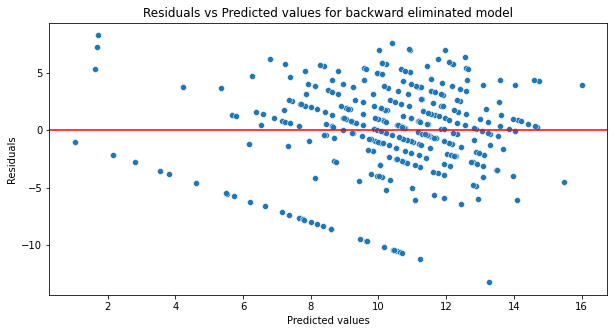

In [156]:
#predicted values vs residuals
plt.figure(figsize=(10,5))
sns.scatterplot(predicted_values1,residuals1)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values for backward eliminated model")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [157]:
#Breusch-Pagan test for homoscedasticity
bnames = ['Lagrange multiplier statistic (for homoscedasticity)', 'p-value','f-value', 'f p-value']
breush = het_breuschpagan(residuals1, results2.model.exog)
print(list(zip(bnames, breush)))

[('Lagrange multiplier statistic (for homoscedasticity)', 42.26046911683721), ('p-value', 0.41632121591215776), ('f-value', 1.0919691025071299), ('f p-value', 0.3335895739844107)]


#### Homoscedasticity assumptions -- fail

### 2. Normality assumption

C:\Users\User\anaconda3\desktop\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


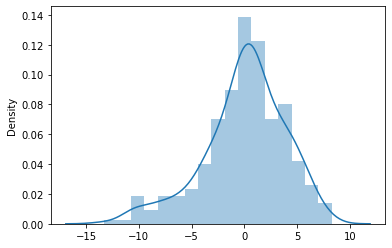

In [158]:
#Normality
sns.distplot(residuals1)
plt.show()

In [159]:
#Shapiro-Wilk normality test. 
#Normality assumption isn't held.
snames=['The test statistic for Normality', 'p-value']
shapiro_test=shapiro(residuals1)
print(list(zip(snames, shapiro_test)))

[('The test statistic for Normality', 0.9666527509689331), ('p-value', 5.924467245677079e-07)]


#### Normality assumption -- fail

### 3. Linearity assumption

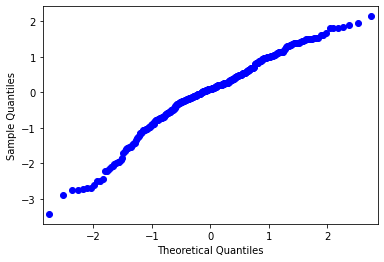

In [160]:
#QQ plot
qqplot(residuals1,fit=True)
plt.show()

In [161]:
#Linearity 
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results2)
print(list(zip(rnames, rainbow)))

[('fstat', 1.0274889723253815), ('p-value', 0.43841853864924196)]


#### Linearity assumption is held

## Let's check multicollinearity

#### VIF: measure of the amount of multicollinearity in a set of multiple regression variables.

In [162]:
x_list=X.columns.tolist()

In [163]:
#Multicollinearity
#calculating vif using variance_inflation_factor() function from statsmodel
vif = [variance_inflation_factor(X[x_list].values, i) for i in range(0,len(x_list))]

C:\Users\User\anaconda3\desktop\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [164]:
#vif values with variable names
#No multicollinearity
for i in range(0,len(x_list)):
    print(x_list[i],":",vif[i])

const : 469.9660010105214
age : 1.7936717898143895
Medu : 2.9222399538473027
Fedu : 2.1308598959319554
traveltime : inf
studytime : 1.3606716492878577
failures : 1.4309310866356277
famrel : 1.1352691830120933
freetime : inf
goout : inf
Dalc : inf
Walc : inf
health : 1.1699588447435358
absences : 1.2547140033036015
school2_MS : 1.5090489920632029
sex_M : 1.4589468662973075
address_U : 1.3828288348391988
famsize_LE3 : 1.1455750537439806
Pstatus_T : 1.1409987008928193
Mjob_health : 2.3022800581000054
Mjob_other : 2.732592521491718
Mjob_services : 2.8720668819018123
Mjob_teacher : 3.1606127700697564
Fjob_health : 2.1050002327535213
Fjob_other : 6.064703574108931
Fjob_services : 5.283391756043996
Fjob_teacher : 2.6766666650817177
reason_home : 1.4343260604884422
reason_other : 1.2959622304869223
reason_reputation : 1.518549206552329
guardian_mother : 1.4873412986150167
guardian_other : 1.740742158153267
schoolsup_yes : 1.1706638836397607
famsup_yes : 1.272798339296131
paid_yes : 1.326279304

Although, the vif of const is too high, let's ignore that, since, it is mannually added